In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import os
%matplotlib inline

In [4]:
### convert MNIST image files into a tensor of 4-Dimensions (# of images, height, width, color channels)
transform = transforms.ToTensor()

In [6]:
### train data
train_data = datasets.MNIST(root="./cnn_data", train=True, download = True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3974042.68it/s]


Extracting ./cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to ./cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 481388.72it/s]


Extracting ./cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 858638.13it/s] 


Extracting ./cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11781403.07it/s]

Extracting ./cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./cnn_data/MNIST/raw



In [8]:
### test data
test_data = datasets.MNIST(root="./cnn_data", train=False, download = True, transform=transform)

In [10]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./cnn_data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./cnn_data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [16]:
### create a small batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [17]:
### Define our CNN Model
## describe convolutional layer and what it's doing
conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3))


In [20]:
### Grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
    break

In [22]:
### one image in MNIST
X_train.shape

torch.Size([1, 28, 28])

In [33]:
x = X_train.view(1,1,28,28)   ### 4 channels

In [34]:
## perform out first convolution

In [35]:
x = F.relu(conv1(x)) ## rectified linear unit for our activation functions

In [36]:
x.shape

torch.Size([1, 32, 26, 26])

In [37]:
x =F.max_pool2d(x, kernel_size=(2,2)) ### kernel of 2 and stride of 2

In [38]:
x.shape

torch.Size([1, 32, 13, 13])

In [39]:
### Do our second convolutional layer
x = F.relu(conv2(x))

In [40]:
x.shape

torch.Size([1, 64, 11, 11])

In [41]:
x = F.max_pool2d(x, kernel_size=(2,2))

In [42]:
x.shape

torch.Size([1, 64, 5, 5])

In [43]:
### Model class
class CNN(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
     super().__init__(*args, **kwargs)
     self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
     self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3))
     ### Fully connected Layer
     self.fc1 = nn.Linear(in_features=64*5*5, out_features=128)
     self.fc2 = nn.Linear(in_features=128, out_features=64)
     self.out = nn.Linear(in_features=64, out_features=10)

  def forward(self, x):
    x = F.relu(self.conv1(x)) # forward
    x = F.max_pool2d(x, kernel_size=(2,2)) # pool
    x = F.relu(self.conv2(x)) # forward
    x = F.max_pool2d(x, kernel_size=(2,2)) # pool

    ### Re-View to flatten it our
    x = x.view(-1, 64*5*5)
    ### fully connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return F.log_softmax(x, dim=1)

In [45]:
### create an instance of our model
torch.manual_seed(101)
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

In [46]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # the smaller the learning rate, longer its gonna take to train


In [49]:
import time
start_time = time.time()

### Create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

### for loop of epochs
### Train our model
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  ### Train
  for b, (X_train, y_train) in enumerate(train_loader): ### batch
    b+=1  ### start out batch at 1
    y_pred = model(X_train) ## get predicted values from the training set. Not flattened
    loss = criterion(y_pred, y_train) ## compare predicted with answers

    Prediction = torch.max(y_pred.data, 1)[1] ## add up the number of correct predictions
    batch_corr = (Prediction == y_train).sum()
    trn_corr += batch_corr

    ### update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 == 0:
      print(f'epoch: {i}  batch: {b}  loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  ### Test
  with torch.no_grad():  ## no gradient so we don't update the weights and biases with the test set
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()
      # print(f'epoch: {i}  batch: {b}  loss: {loss.item()}')

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total_time = current_time - start_time
print(total_time)

epoch: 0  batch: 600  loss: 0.1274968683719635
epoch: 0  batch: 1200  loss: 0.3507916331291199
epoch: 0  batch: 1800  loss: 0.1573498547077179
epoch: 0  batch: 2400  loss: 0.20424577593803406
epoch: 0  batch: 3000  loss: 0.026539240032434464
epoch: 0  batch: 3600  loss: 0.06734243035316467
epoch: 0  batch: 4200  loss: 0.0007630902691744268
epoch: 0  batch: 4800  loss: 0.02074444852769375
epoch: 0  batch: 5400  loss: 0.07245920598506927
epoch: 0  batch: 6000  loss: 0.00853294599801302
epoch: 1  batch: 600  loss: 0.06874513626098633
epoch: 1  batch: 1200  loss: 0.49104708433151245
epoch: 1  batch: 1800  loss: 0.039502423256635666
epoch: 1  batch: 2400  loss: 0.0021710526198148727
epoch: 1  batch: 3000  loss: 0.14124128222465515
epoch: 1  batch: 3600  loss: 0.0043918779119849205
epoch: 1  batch: 4200  loss: 0.0005037133814767003
epoch: 1  batch: 4800  loss: 0.05755751207470894
epoch: 1  batch: 5400  loss: 0.001069745747372508
epoch: 1  batch: 6000  loss: 0.0012803069548681378
epoch: 2  ba

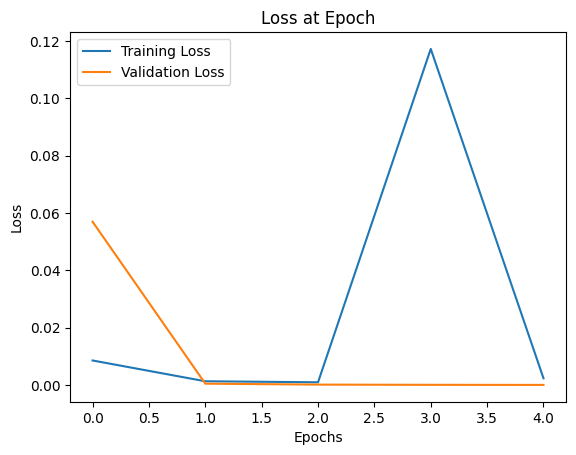

In [51]:
### graph the loss of epoch
train_losses = [t.cpu().detach().numpy() for t in train_losses]
test_losses = [t.cpu().detach().numpy() for t in test_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

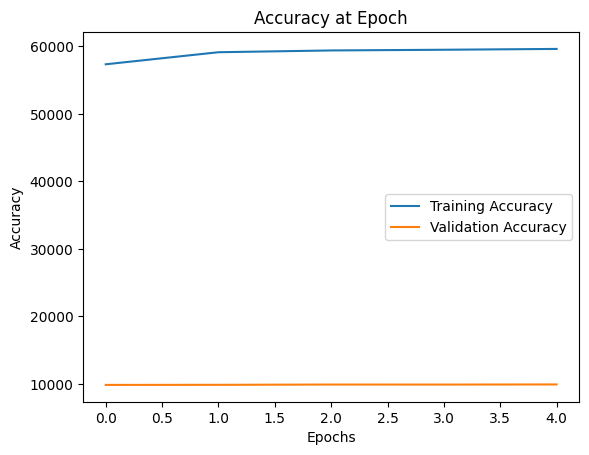

In [52]:
### graph the accuracy at the end of each epoch
plt.plot(train_correct, label="Training Accuracy")
plt.plot(test_correct, label="Validation Accuracy")
plt.title("Accuracy at Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [53]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [54]:
with torch.no_grad():
  correct = 0
  for b, (X_test, y_test) in enumerate(test_load_everything):
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

In [55]:
correct.item()/len(test_data)*100

99.14

In [59]:
## grab an image
test_data[400][0].shape

torch.Size([1, 28, 28])

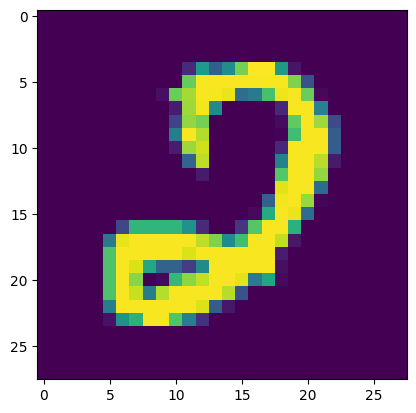

In [61]:
new_image = test_data[400][0].reshape(28,28)
plt.imshow(new_image)

In [63]:
### pass the image thru our model
model.eval()
with torch.no_grad():
  test_image = test_data[400][0].view(1,1,28,28)
  new_prediction = model(test_image)

In [66]:
## check new predictions
new_prediction

tensor([[-1.3559e+01, -1.4220e+01, -7.2717e-06, -1.4281e+01, -1.5270e+01,
         -1.9018e+01, -2.2446e+01, -1.2465e+01, -1.4612e+01, -1.6843e+01]])